In [4]:
import numpy as np
import plate_map as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from unidec_modules import unidectools as ud
from copy import deepcopy 
from unidec_modules.SeqChrom2 import *
import scipy
from copy import deepcopy
import copy

In [68]:
# folder = "D:\\2021 mbp time courses v2\\10"
# map_path = "C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\reaction maps\\MBP labelling x5.xlsx"
folder = "C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\data"


In [80]:
filenames = os.listdir(folder)
engines = []
eng = SeqChrom()
paths = []
for f in filenames: # see def auto_from_wizard(data, filename, mode):

    
    if f[-4:] == "mzML":
        path = os.path.join(folder, f)
        paths.append(path)
#         eng.parse_file(path)
eng.import_mzml(paths)

        #         print(path)
#         eng.data.new_file(f)
#         eng.data.add_file(path = path)
#         eng.data.export_hdf5()


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe
Parsing File: C:\Users\cm19ljc\Documents\GitHub\UniDec\data\06-10-21 MBP-GV tc from 27-09-2_RE6_01_79513.d.mzML
06-10-21 MBP-GV tc from 27-09-2_RE6_01_79513.d.mzML
Reading mzML: C:\Users\cm19ljc\Documents\GitHub\UniDec\data\06-10-21 MBP-GV tc from 27-09-2_RE6_01_79513.d.mzML
[Warning] Not index found and build_index_from_scratch is False
Converted to gzip file to improve speed: C:\Users\cm19ljc\Documents\GitHub\UniDec\data\06-10-21 MBP-GV tc from 27-09-2_RE6_01_79513.d.mzML.gz
Reading mzML: C:\Users\cm19ljc\Documents\GitHub\UniDec\data\06-10-21 MBP-GV tc from 27-09-2_RE6_01_79513.d.mzML
[Warning] Not index found and build_index_from_scratch is False
Converted to gzip file to improve speed: C:\Users\cm19ljc\Documents\GitHub\UniDec\data\06-10-21 MBP-GV tc from 27-09-2_RE6_01_79513.d.mzML.gz


In [83]:
eng.process_data()

Execution Time: 0.0696648000011919


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [82]:
eng.data.__dict__


{'names': [],
 'indexes': [],
 'spectra': [],
 'topname': 'ms_dataset',
 'filename': None,
 'massdat': [],
 'data2': [],
 'massgrid': [],
 'mzgrid': [],
 'mzdat': [],
 'exgrid': [],
 'exvals': [],
 'peaks': [],
 'var1': [],
 'var2': [],
 'v1name': 'Variable 1',
 'v2name': 'Variable 2',
 'len': 0,
 'eng': <unidec_modules.SeqChrom2.SeqChrom at 0x19a78caafa0>,
 'fitgrid': [],
 'fits': []}

07-10-21 MBP-GV labelling 2eq 1_BD1_01_79540.d_extracts.txt
07-10-21 MBP-GV labelling 2eq 1_BD1_01_79540.d_peaks.txt
12-10-21 E2_333417_RB8_01_79610.d_extracts.txt
12-10-21 E2_333417_RB8_01_79610.d_peaks.txt
15-10-21 E2 10_333695_BE3_01_79677.d_extracts.txt
15-10-21 E2 10_333695_BE3_01_79677.d_peaks.txt


In [6]:
self = eng
def process_maps(self):

    

    groupby = 'Reaction' # Reaction OR Substrate Conc

    rmap = wells.copy()
    self.rmap = rmap[rmap['Type'] != 'empty']
    self.rmap.loc[:, 'Species'] = np.nan

    for skey, sval in species.groupby(['Reaction']):
        splist = [Species(spval.to_dict('records')[0], name = spkey) for spkey, spval in sval.groupby('Species')]
        splist = colorcodeclass(splist)

        for s in splist:
            self.rmap.loc[:, s.__name__] = np.nan
            self.rmap.loc[rmap['Reaction']==skey, s.__name__] = self.rmap.apply(lambda _:deepcopy(s), axis = 1)

        spnames = [s.__name__ for s in splist]
        self.rmap.loc[rmap['Reaction']==skey, 'Species'] = self.rmap.apply(lambda _:spnames, axis = 1)

    # update_vars

    if len(self.data.spectra) == len(self.rmap):
        for i, s in enumerate(self.data.spectra):
            well_id = self.rmap.index[i]
            timevar = self.rmap['Time'].iloc[i]
            s.attrs['Variable 1'] = well_id
            s.var1 = well_id
            s.attrs['Variable 2'] = timevar
            s.var2 = timevar
            self.rmap.loc[well_id, 'Spectra'] = s



    spectra = {s.var1:s for s in self.data.spectra}

    # update species with well info/metadata 

    groupby = 'Reaction' # Reaction OR Substrate Conc

    for index, row in self.rmap.iterrows():
        for specs in row['Species']:
            row[specs] = deepcopy(row[specs])
            row[specs].coord = row.name
    #         print(row[specs])
            vals = row[~row.index.isin(row['Species'])].to_dict()
            row[specs].__dict__.update(vals)
    return self
            
# match peaks
# prep 

def peak_match(self, window = 10):
    window = 10

    intmat = np.array([])

    for index, row in self.rmap.iterrows():

        rowints = np.array([])

        specieslist = list(row[row.index.isin(row['Species'])])
        theory_masses = np.array([sp.Mass for sp in specieslist])
        data_masses = np.array([p.mass for p in row['Spectra'].pks.peaks])
        pks = np.array([p for p in row['Spectra'].pks.peaks])

        # match algorithm 
        tm, dm = np.meshgrid(theory_masses, data_masses)
        diff = abs(tm - dm)
        diff[diff>window] = np.nan
        for i, d in enumerate(diff):
            if np.isnan(d).all()==False:
                minimum = np.nanargmin(d)
                data_peak = data_masses[i]

                specieslist[minimum].peak = pks[i]
                specieslist[minimum].integral = pks[i].integral[0]
                print("{}, {} = {}".format(row[row.index.isin(row['Species'])][minimum].__name__, data_peak, pks[i]))

                row[row.index.isin(row['Species'])][minimum].integral = pks[i].integral[0]
                row[row.index.isin(row['Species'])][minimum].peak = pks[i]
                np.append(rowints, pks[i].integral[0])
                print(row[row.index.isin(row['Species'])][minimum].integral)

    return self


1292 2
Noise Level: 0.03140379387827018 Window: 0.05
Bad Peak [0.419617   0.49743127] 0.24185 [0.419617, 0.661467]
Bad Peak [0.602833   0.43116003] 0.246016 [0.419617, 0.665633]
1.20162 0.16199999999999992
Bad Peak [1.60878    0.03991895] 0.5526 [1.13515, 1.68775]
2.17298 0.15791999999999984
3.08303 0.14544999999999986
4.01398 0.1662300000000001
4.93242 0.1620499999999998
5.95905 0.054059999999999775
Getting scans: [135, 174]
Length merge axis: 38024
Getting scans: [356, 380]
Length merge axis: 37136
Getting scans: [569, 604]
Length merge axis: 38358
Getting scans: [793, 833]
Length merge axis: 38091
Getting scans: [1018, 1057]
Length merge axis: 38081


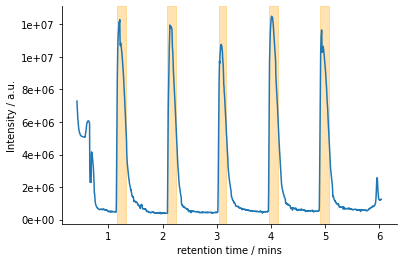

Execution Time: 0.7421698999999933
Execution Time: 2.1675914000000205
Execution Time: 0.25372319999999604
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\07-10-21 MBP-GV labelling 2eq 1_BD1_01_79540.d_extracts.txt


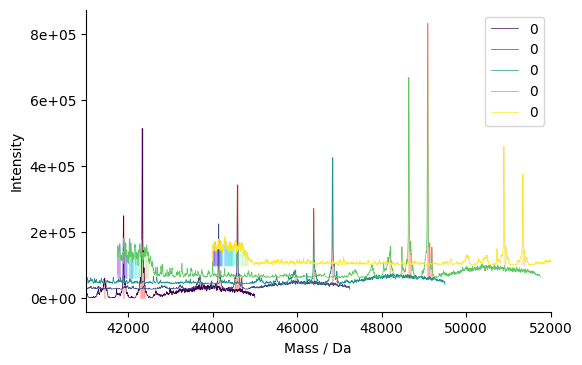

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC310D0>
3364432.5
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC31130>
6932253.5
MBP-GVSEYG, 41889.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC31820>
2746038.0
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC318E0>
4347988.0
MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC31F70>
3078666.2
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC31FA0>
5222344.5
MBP-GVSEYG, 41889.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC43520>
8150076.5
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC43580>
10524241.0
MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC43CA0>
4868578.0
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FAFC43D00>
3699190.5
GVSEYG:0
H7D:0
MBP-GVSEYG:0.3

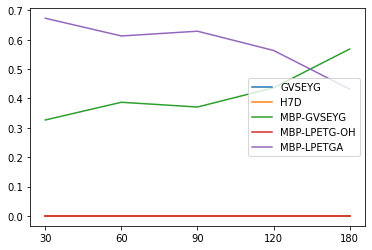

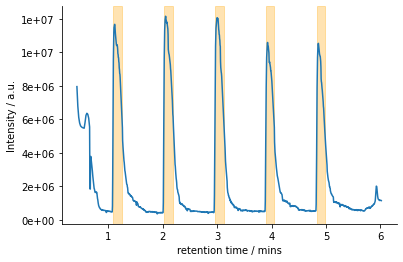

Execution Time: 0.08710519999999633
Execution Time: 2.2498435999999913
Execution Time: 0.38558570000000714
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\08-10-21 mbp gv 2 eq 25 pc_3332_GD2_01_79580.d_extracts.txt


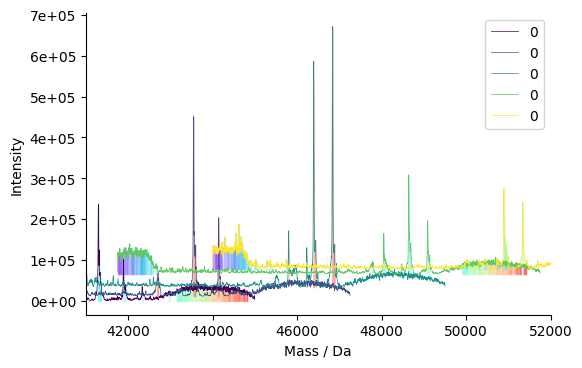

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

MBP-GVSEYG, 41891.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8A430>
1458325.4
MBP-LPETGA, 42334.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8A490>
525688.3
MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8BA60>
2755925.2
MBP-LPETG-OH, 41296.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8BF40>
1874393.5
MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8BFA0>
7575062.0
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A99040>
8648231.0
MBP-GVSEYG, 41889.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A998B0>
3307405.5
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A99910>
1759768.4
MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FB85BCE50>
2712466.2
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FB85BCF40>
2321222.0
GVSEYG:0
H7D:0
MBP-GVSEYG:0.7

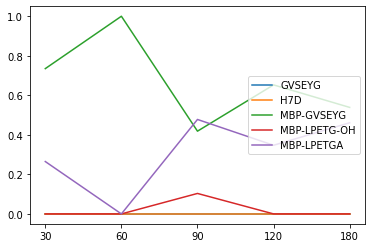

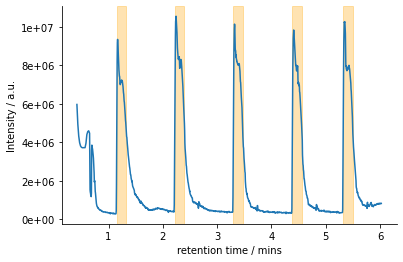

Execution Time: 0.06512860000000842
Execution Time: 2.0945279000000028
Execution Time: 0.30062019999999734
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\21-09-21 MBP labelling reverse_extracts.txt


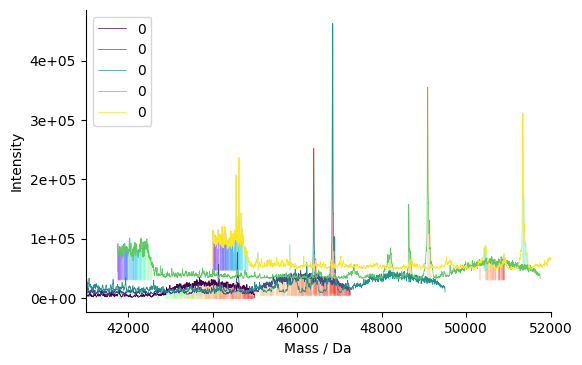

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

MBP-LPETG-OH, 41279.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A2B880>
131610.89
MBP-GVSEYG, 41891.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013579850>
731676.94
MBP-LPETGA, 42336.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013579F70>
1022894.75
MBP-GVSEYG, 41890.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8B400>
3310160.5
MBP-LPETGA, 42335.0 = <unidec_modules.peakstructure.Peak object at 0x0000022013A8BB80>
6227484.5
MBP-GVSEYG, 41889.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FB9E9EF70>
1660478.8
MBP-LPETGA, 42336.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FB9E9EFA0>
4649682.5
MBP-GVSEYG, 41894.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FB9E95340>
396721.22
MBP-LPETGA, 42336.0 = <unidec_modules.peakstructure.Peak object at 0x0000021FB9E95C70>
3778072.8
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0.38791418075561523
MBP-LPETG-OH:0.0697763

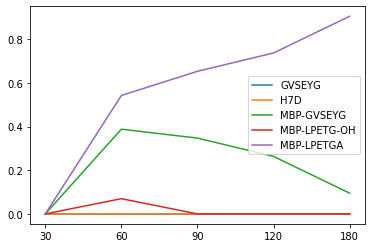

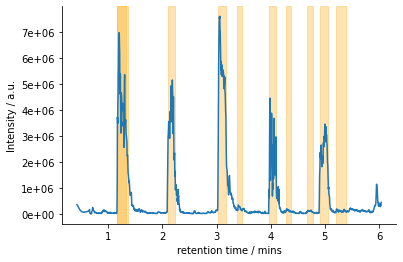

Execution Time: 0.0754177000000027
Execution Time: 3.4673641999999916
Execution Time: 0.6882506999999976
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\23-09-21 E1 MBP-GV 10 H7D 1-5 GV_3_RE2_01_79392_extracts.txt


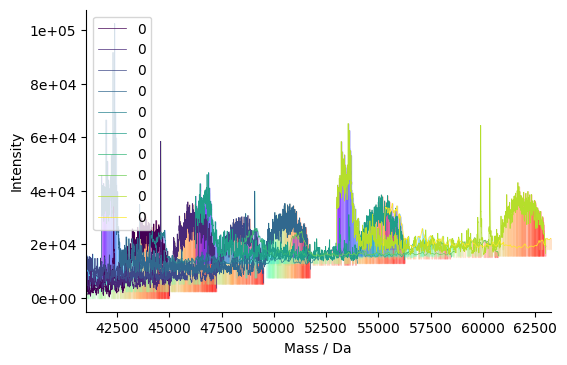

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

D:\2021 MBP time courses\23-09-21 E1 MBP-GV 10 H7D 1-5 GV_3_RE2_01_79392.mzML failed
1309 2
Noise Level: 0.028012374188701665 Window: 0.05
0.635 0.09613400000000005
0.743517 0.10808299999999993
1.2008 0.13298999999999994
1.58317 0.05820000000000003
2.13612 0.15793000000000035
2.22755 0.1787399999999999
3.05892 0.14959999999999996
3.46622 0.0997300000000001
4.04812 0.1496000000000004
Bad Peak [4.40973    0.03651383] 0.5735600000000001 [3.93592, 4.50948]
4.95005 0.1038800000000002
Bad Peak [5.25347   0.0411556] 0.5112299999999994 [4.8711, 5.38233]
5.95593 0.06233000000000022
Getting scans: [136, 168]
Length merge axis: 34502
Getting scans: [231, 245]
Length merge axis: 5047
Getting scans: [360, 398]
Length merge axis: 37326
Getting scans: [359, 402]
Length merge axis: 37326
Getting scans: [585, 621]
Length merge axis: 38075
Getting scans: [683, 707]
Length merge axis: 4836
Getting scans: [811, 847]
Length merge axis: 34520
Getting scans: [1036, 1061]
Length merge axis: 33138


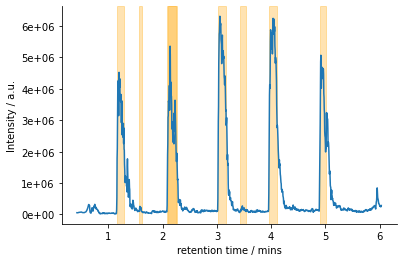

Execution Time: 0.06844999999998436
Execution Time: 3.0922775999999885
Execution Time: 0.36816279999999324
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\23-09-21 E1 run 2_332032_RE4_01_79394_extracts.txt


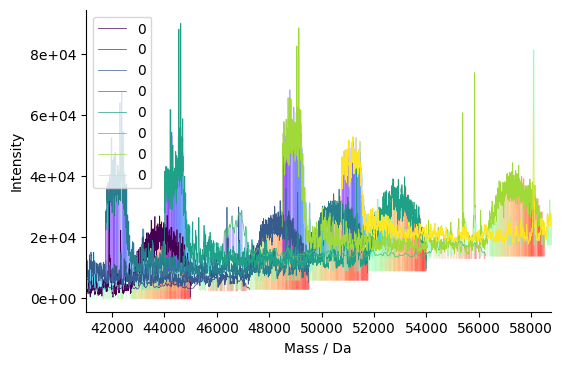

D:\2021 MBP time courses\23-09-21 E1 run 2_332032_RE4_01_79394.mzML failed
1312 2
Noise Level: 0.04092813107419656 Window: 0.05
0.635183 0.07948299999999997
0.743667 0.0457169999999999
1.15515 0.09145000000000003
2.08633 0.0665
3.06312 0.15383000000000013
Bad Peak [3.84053    0.05647336] 0.5278999999999998 [3.82388, 4.35178]
3.9694 0.12467000000000006
Bad Peak [4.20215    0.05372959] 0.6858800000000005 [3.81972, 4.5056]
Bad Peak [4.32683   0.0443619] 2.3066500000000003 [3.73658, 6.04323]
4.90465 0.11637999999999948
Bad Peak [5.13327    0.05368315] 1.00141 [4.84647, 5.84788]
Bad Peak [5.36182    0.04289871] 2.3108000000000004 [3.73243, 6.04323]
Bad Peak [5.48225    0.04416559] 2.3066500000000003 [3.73658, 6.04323]
Bad Peak [5.56533    0.04175128] 3.28771 [2.75552, 6.04323]
5.9518 0.024939999999999962
Bad Peak [6.02662    0.05770331] 0.03325000000000067 [6.00998, 6.04323]
Getting scans: [129, 151]
Length merge axis: 700
Getting scans: [350, 366]
Length merge axis: 1287
Getting scans: [57

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

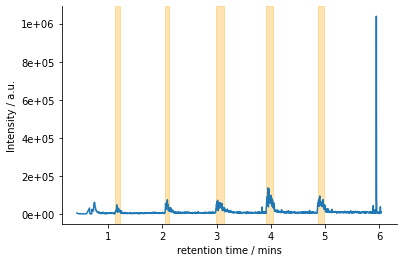

Execution Time: 0.04119649999995545
Execution Time: 0.4876074000000017
Execution Time: 0.1651124999999638
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\23-09-21 E2 MBP-GV_332061_extracts.txt


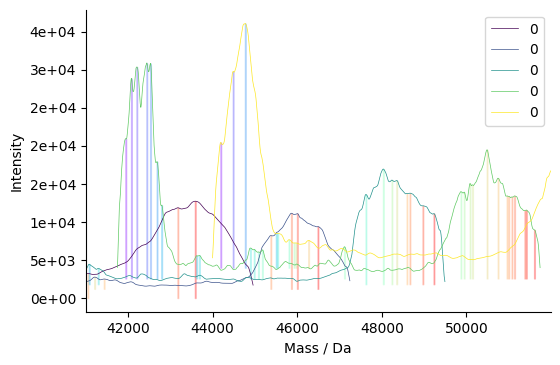

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
1310 2
Noise Level: 0.05159681834311393 Window: 0.05
0.635167 0.07946699999999995
0.706233 0.07066700000000004
1.16352 0.09561999999999982
1.72468 0.19124999999999992
3.02593 0.1372
3.9405 0.16627000000000036
Bad Peak [4.26053   0.1343231] 1.9910600000000005 [3.89477, 5.88583]
Bad Peak [4.3686     0.11064718] 2.0742100000000003 [3.89477, 5.96898]
Bad Peak [4.44757    0.11223874] 2.0742100000000003 [3.89477, 5.96898]
Bad Peak [4.65538    0.09113106] 2.0949999999999998 [3.89062, 5.98562]
Bad Peak [4.73852    0.09267633] 2.0949999999999998 [3.89062, 5.98562]
4.9339 0.12471999999999994
Bad Peak [5.31632    0.19025983] 1.0267599999999995 [4.82582, 5.85258]
Bad Peak [5.46183    0.14760964] 1.2387500000000005 [4.63045

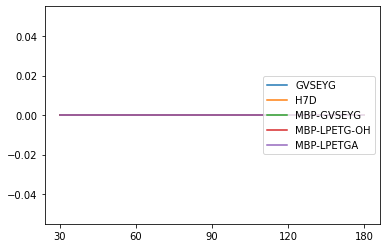

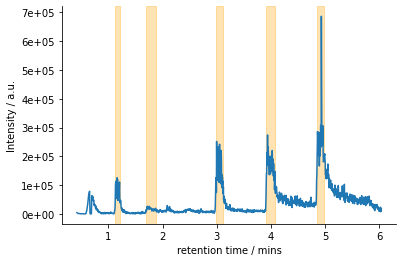

Execution Time: 0.04535099999998238
Execution Time: 0.8441662999999835
Execution Time: 0.3031691999999566
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\24-09-21 MBP-GV E1 run 3_332163_GD3_01_79463_extracts.txt


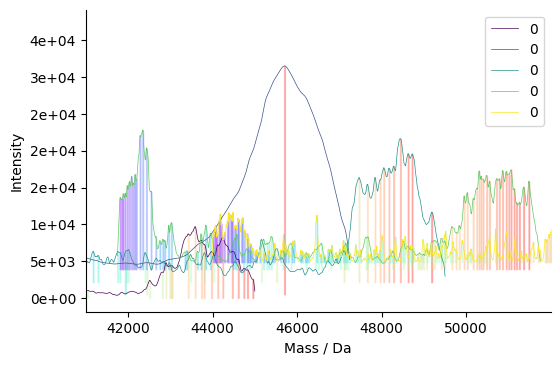

C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

MBP-LPETG-OH, 41286.0 = <unidec_modules.peakstructure.Peak object at 0x000002202D63F340>
15419.336
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:1.0
MBP-LPETGA:0
1305 2
Noise Level: 0.06751872607659337 Window: 0.05
Bad Peak [0.415583  0.6779365] 0.25436700000000007 [0.415583, 0.66995]
Bad Peak [0.5988     0.51847148] 0.262684 [0.415583, 0.678267]
Bad Peak [1.1604 1.    ] 0.23687999999999998 [1.13547, 1.37235]
Bad Peak [1.24767    0.86654407] 0.25351999999999997 [1.1313, 1.38482]
Bad Peak [2.0997     0.94811086] 0.21605000000000008 [2.07477, 2.29082]
Bad Peak [2.21187   0.7733286] 0.22851 [2.07477, 2.30328]
Bad Peak [3.04303    0.89419822] 0.20775999999999994 [3.01812, 3.22588]
Bad Peak [3.98238    0.91074192] 0.22021999999999986 [3.95745, 4.17767]
Bad Peak [4.92578    0.

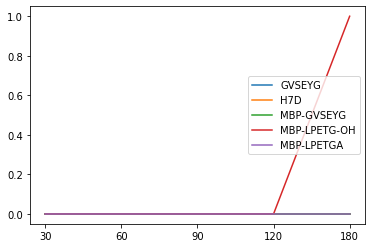

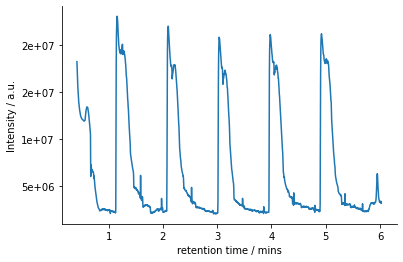

Execution Time: 0.05307769999996026
Execution Time: 0.03543910000001915
D:\2021 MBP time courses\26-08-21 MBP labelling multi in_BA5_01_78927.mzML failed
1295 2
Noise Level: 0.06050002518736477 Window: 0.05
Bad Peak [0.418567   0.61818237] 0.21651599999999993 [0.418567, 0.635083]
Bad Peak [0.551817   0.46114384] 0.23318300000000003 [0.418567, 0.65175]
1.06357 0.15792000000000006
1.99457 0.14961999999999986
2.93392 0.14964999999999984
3.8732 0.1787200000000002
4.80827 0.16209000000000007
Bad Peak [5.90545    0.11442369] 0.19115000000000038 [5.78078, 5.97193]
Bad Peak [5.97193    0.11155311] 0.19530000000000047 [5.77663, 5.97193]
Getting scans: [107, 145]
Length merge axis: 36894
Getting scans: [332, 368]
Length merge axis: 38140
Getting scans: [558, 594]
Length merge axis: 38636
Getting scans: [783, 826]
Length merge axis: 38547
Getting scans: [1008, 1047]
Length merge axis: 39737


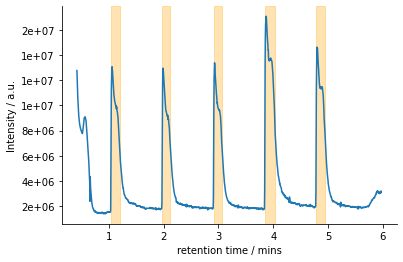

Execution Time: 0.07946329999998625
Execution Time: 2.1808229000000097
Execution Time: 0.14495429999999487
Peak info saved to: D:\2021 MBP time courses\UniDec_Figures_and_Files\multi injection v3_extracts.txt


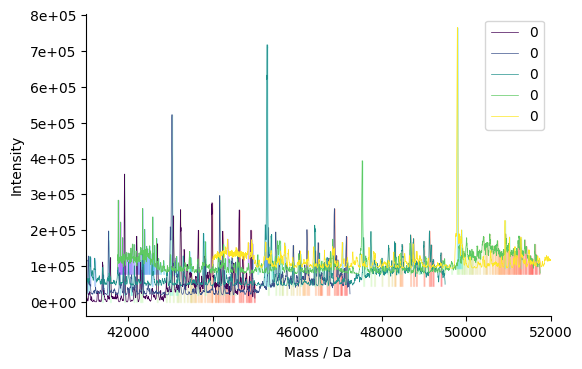

MBP-LPETGA, 42331.0 = <unidec_modules.peakstructure.Peak object at 0x000002202E0391F0>
1280075.5
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:1.0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0
GVSEYG:0
H7D:0
MBP-GVSEYG:0
MBP-LPETG-OH:0
MBP-LPETGA:0


C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\cm19ljc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

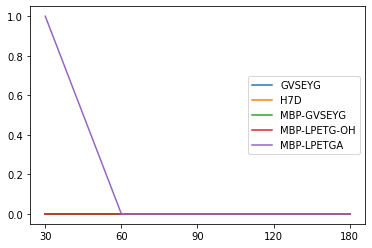

In [7]:
for eng in engines:
    try:
        eng.config.chrom_peak_width = 0.05 
        eng.get_chrom_peaks(lb = 1, ub = 5.5) 
        eng.add_chrom_peaks2() 
        eng.plot_tic(peak_windows = True)
        eng.update_config(masslb = 35000, massub = 45000, minmz = 500, peakthresh = 0.1)
        eng.process_data()
        eng.run_unidec()
        eng.pick_peaks()
        eng.integrate_all()
        eng.plot_all(dtype = 'massdat', combine = True, cmap = 'viridis', xlim = [41000, 43000])
        rmap = eng.upload_map(map_path)
        species, wells = eng.upload_map(map_path)
        species, wells = eng.upload_map(map_path)
        eng = process_maps(eng)
        eng = peak_match(eng)
        self = eng
        # ----------------------------------------------------------------
        for index, row in self.rmap.iterrows():
            ints = []
            for s in row[row['Species']]:
                if type(s.integral) != list:
                    ints.append(s.integral)

        #     ints = np.array([s.integral for s in row[row['Species']]])
            sum_ints = np.sum(ints)
            for s in row[row['Species']]:
                if type(s.integral) != list:
                    s.percentage = s.integral/sum_ints
                else:
                    s.percentage = 0
                print("{}:{}".format(s.__name__, s.percentage))
        # -------------------------------------------------------------------
            # get data

        species = None
        datatype = 'percentage'
        rxndct = {}
        groupby = 'Reaction'
        for k, v in self.rmap.groupby(groupby):

            time = v['Time']
            speciesdct = {}
            speciestimedct = {}

            for index, row in v.iterrows():
                if species == None:
                    species = row.Species

                if len(species) == 1:
                    species = [species]
                for s in species:
                    if s in speciesdct:
                        speciesdct[s].append(getattr(row[s], datatype))
                        speciestimedct[s].append(row['Time'])
                    else:
                        speciesdct[s] = [getattr(row[s], datatype)]
                        speciestimedct[s] = [row['Time']]
            for name, y in speciesdct.items():

                plt.plot(time, y, label = name)
                plt.legend(loc = "center right")
                plt.show

        rxndct[k] = pd.DataFrame(speciesdct, index = time)
        # ---------------------------------------------------------------------------
        self.datadct = rxndct
    except Exception: 
        print("{} failed".format(eng.path))

In [8]:
# def percentage_species(self):
#     for index, row in self.rmap.iterrows():
        
#         ints = np.array([s.integral for s in row[row['Species']]])
#         sum_ints = np.sum(ints)
#         for s in row[row['Species']]:
#             s.percentage = s.integral/sum_ints
            
# percentage_species(self)

In [9]:

speciesdct

{'GVSEYG': [0, 0, 0, 0, 0],
 'H7D': [0, 0, 0, 0, 0],
 'MBP-GVSEYG': [0, 0, 0, 0, 0],
 'MBP-LPETG-OH': [0, 0, 0, 0, 0],
 'MBP-LPETGA': [1.0, 0, 0, 0, 0]}

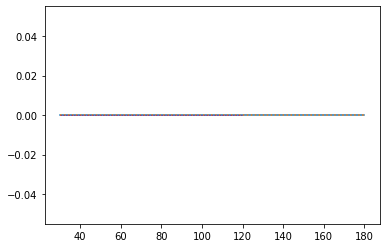

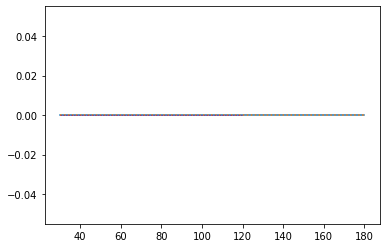

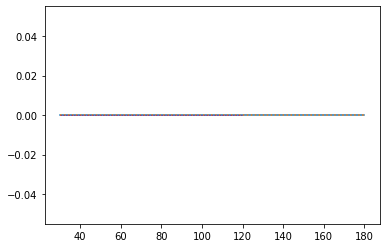

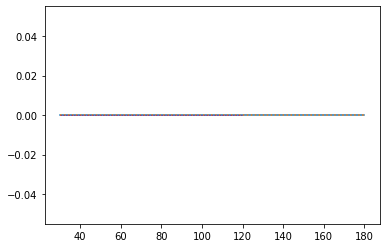

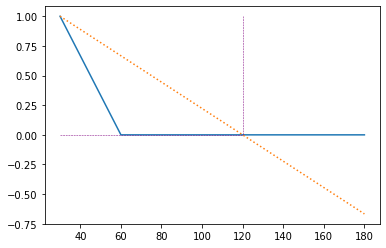

In [10]:
# thresh = 0.8
# ratedct = {}
# for key, data in rxndct.items():
#     x = np.array(data.index, dtype = float)
#     x1i = int(len(x)*thresh -1)
#     if x1i == 0:
#         x1i = int(len(x)*thresh)
#     if x1i == 0:
#         x1i = 1
#     x1 = float(x[x1i])
    
#     y1 = data.iloc[x1i, :]
#     y0 = data.iloc[0, :]
#     x0 = float(x[0])
    
#     m = (y0-y1)/(x0-x1)
#     ratedct[key] = m
#     c = y1-m*x1
#     for species in data.columns:
#         vy = m[species]*x +c[species]
#         fig, ax = plt.subplots()
#         ax.plot(x, data[species])
#         ax.plot(x, vy, linestyle = 'dotted')
        
#         ax.plot((x0, x1), (y1[species], y1[species]), color = 'purple', linestyle = 'dashed', linewidth = 0.5)
#         ax.plot((x1, x1), (y0[species], y1[species]), color = 'purple', linestyle = 'dashed', linewidth = 0.5)

In [11]:
ratedct

{'MBP labelling': GVSEYG         -0.000000
 H7D            -0.000000
 MBP-GVSEYG     -0.000000
 MBP-LPETG-OH   -0.000000
 MBP-LPETGA     -0.011111
 dtype: float64}

In [12]:
def michaelis(x, Vm, Km):
    return Vm*x/(x + Km)

In [ ]:
vm, km

In [13]:
key_species = "MBP-LPETGA"
x = []
y = []
for key, val in ratedct.items():
    x.append(float(key))
    y.append(val[key_species])
params, covar = scipy.optimize.curve_fit(michaelis, x, y, absolute_sigma = False)
vm, km = params[0], params[1]

plt.plot(x, y)
plt.show()

ValueError: could not convert string to float: 'MBP labelling'